# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
seed = 69
set_seed(seed)


2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
from common_utils import MLP, CustomDataset, loss_fn


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
from common_utils import preprocess_dataset

no_folds = 5

def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """

    kf = KFold(n_splits=no_folds, shuffle=True, random_state=seed)

    X_train_scaled_dict = {}
    y_train_dict = {}
    X_val_scaled_dict = {}
    y_val_dict = {}

    for batch_size in parameters:
        X_train_list = []
        y_train_list = []
        X_val_list = []
        y_val_list = []

        for _exp, (train_index, val_index) in enumerate(kf.split(X_train)):
            X_train_folds, y_train_folds = X_train[train_index], y_train[train_index]
            X_val_folds, y_val_folds = X_train[val_index], y_train[val_index]

            X_train_folds_scaled, X_val_folds_scaled = preprocess_dataset(
                X_train_folds, X_val_folds
            )
            X_train_list.append(X_train_folds_scaled)
            y_train_list.append(y_train_folds)
            X_val_list.append(X_val_folds_scaled)
            y_val_list.append(y_val_folds)

        X_train_scaled_dict[batch_size] = X_train_list
        y_train_dict[batch_size] = y_train_list
        X_val_scaled_dict[batch_size] = X_val_list
        y_val_dict[batch_size] = y_val_list

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict


df = pd.read_csv("simplified.csv")
df["label"] = df["filename"].str.split("_").str[-2]
label_encoder = preprocessing.LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
X_train = df.drop(["filename", "label"], axis=1)
y_train = df["label"].to_numpy()

batch_sizes = [128, 256, 512, 1024]
(
    X_train_scaled_dict,
    X_val_scaled_dict,
    y_train_dict,
    y_val_dict,
) = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [4]:
from common_utils import EarlyStopper, train_loop, test_loop as val_loop

batch_sizes = [128, 256, 512, 1024]
learning_rate = 0.001
max_epochs = 100
patience = 3


def find_optimal_hyperparameter(
    X_train_scaled_dict,
    X_val_scaled_dict,
    y_train_dict,
    y_val_dict,
    batch_sizes,
    _hyperparameter="batch_size",
):
    cv_accuracies = []
    cv_times = []

    for batch_size in batch_sizes:
        final_val_accuracies = []
        final_train_times = []

        print(f"Batch size {batch_size}:")

        model = MLP(no_features=77, no_hidden=128, no_labels=1)
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)
        early_stopper = EarlyStopper(patience)

        for exp in range(no_folds):
            X_train_folds = X_train_scaled_dict[batch_size][exp]
            y_train_folds = y_train_dict[batch_size][exp]
            X_val_folds = X_val_scaled_dict[batch_size][exp]
            y_val_folds = y_val_dict[batch_size][exp]

            training_data = CustomDataset(X_train_folds, y_train_folds)
            validation_data = CustomDataset(X_val_folds, y_val_folds)
            train_dataloader = DataLoader(
                training_data, batch_size=batch_size, shuffle=True
            )
            val_dataloader = DataLoader(
                validation_data, batch_size=batch_size, shuffle=True
            )

            final_val_accuracy = 0.0
            final_train_time_taken = 0.0

            for _epoch in range(max_epochs):
                train_start_time = time.time()
                _train_loss, _train_accuracy = train_loop(
                    train_dataloader, model, loss_fn, optimizer
                )
                train_end_time = time.time()
                final_train_time_taken = train_end_time - train_start_time

                val_loss, val_accuracy = val_loop(val_dataloader, model, loss_fn)
                final_val_accuracy = val_accuracy

                if early_stopper.early_stop(val_loss):
                    break

            final_val_accuracies.append(final_val_accuracy)
            final_train_times.append(final_train_time_taken)

            print(
                f"Experiment {exp + 1}: Final_val_accuracies: {(100*final_val_accuracy):>0.2f}%, Final_train_time_taken: {final_train_time_taken:>8f}s"
            )

        mean_cv_accuracy = np.mean(np.array(final_val_accuracies), axis=0)
        mean_train_time = np.mean(np.array(final_train_times), axis=0)
        cv_accuracies.append(mean_cv_accuracy)
        cv_times.append(mean_train_time)

        print(
            f"Done! Mean val accuracy: {(100*mean_cv_accuracy):>0.2f}%, Mean time taken to train: {mean_train_time:>8f}s"
        )

    return cv_accuracies, cv_times


cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(
    X_train_scaled_dict,
    X_val_scaled_dict,
    y_train_dict,
    y_val_dict,
    batch_sizes,
    "batch_size",
)


Batch size 128:
Experiment 1: Final_val_accuracies: 72.01%, Final_train_time_taken: 0.325291s
Experiment 2: Final_val_accuracies: 80.39%, Final_train_time_taken: 0.306397s
Experiment 3: Final_val_accuracies: 81.54%, Final_train_time_taken: 0.304806s
Experiment 4: Final_val_accuracies: 84.20%, Final_train_time_taken: 0.310043s
Experiment 5: Final_val_accuracies: 85.15%, Final_train_time_taken: 0.310087s
Done! Mean val accuracy: 80.66%, Mean time taken to train: 0.311325s
Batch size 256:
Experiment 1: Final_val_accuracies: 70.15%, Final_train_time_taken: 0.233298s
Experiment 2: Final_val_accuracies: 78.44%, Final_train_time_taken: 0.229075s
Experiment 3: Final_val_accuracies: 79.97%, Final_train_time_taken: 0.230036s
Experiment 4: Final_val_accuracies: 79.93%, Final_train_time_taken: 0.248763s
Experiment 5: Final_val_accuracies: 82.46%, Final_train_time_taken: 0.247051s
Done! Mean val accuracy: 78.19%, Mean time taken to train: 0.237645s
Batch size 512:
Experiment 1: Final_val_accuracies

5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

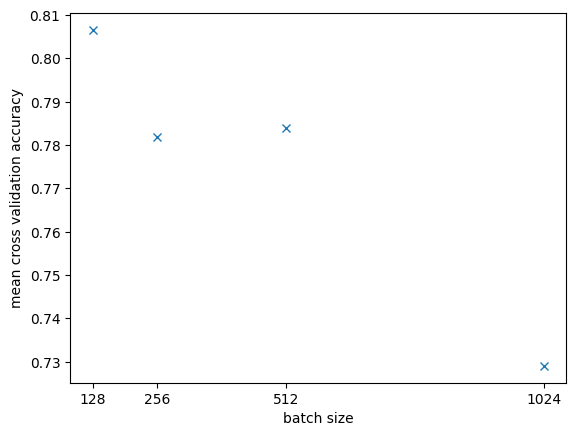

In [5]:
plt.figure(1)
plt.plot(batch_sizes, cross_validation_accuracies, marker="x", linestyle="None")
plt.xticks(batch_sizes)
plt.xlabel("batch size")
plt.ylabel("mean cross validation accuracy")
plt.show()


6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [6]:
df = pd.DataFrame(
    {
        "Batch Size": batch_sizes,
        "Last Epoch Time": cross_validation_times,
    }
)

df


,Batch Size,Last Epoch Time
0,128,0.311325
1,256,0.237645
2,512,0.183027
3,1024,0.178929


In [7]:
optimal_batch_size = 128
reason = "It has the highest mean cross-validation accuracy. While it takes longer to train, its obvious advantage over the next best alternative (batch size = 512) in terms of accuracy outweighs the slight disadvantage of longer training time."
